# prep

In [2]:
import pickle
from caiman.base.rois import register_multisession
from caiman.utils import visualization
from caiman.base.rois import extract_binary_masks_blob
from IPython.display import clear_output

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
import numpy as np
import os
import pickle
# from custom_functions import loadmat

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

import matplotlib as mpl
mpl.rcParams.update({
    'figure.figsize': (18, 13),
})

Loading BokehJS ...

In [3]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

# construct data list
all cells' flattened spatial footprints of the same FOV over 6 days  
template (correlation image) for each day  
- spatial is a list where each entry is the matrix of the good spatial components (cells) for each session  
- templates is a list where each entry is the correlation image for each session

## correlation image list

In [4]:
root_dir = 'C:/Users/ll357/Documents/CaImAn/demos/temp_data/'
mouse_date = 'i1369_220310' # V1 high res young mouse
root_dir = root_dir + mouse_date
os.chdir(root_dir)

def load_Cn_pickle(filename):
    f = open(filename, 'rb')
    Cn = pickle.load(f)
    f.close()
    return Cn

Cn_name_list = glob.glob('*Cn*.pckl')
Cn_list = [load_Cn_pickle(f) for f in Cn_name_list]

def load_caiman_hdf(filename):
    cnm = cnmf.load_CNMF(filename, n_processes=n_processes, dview=dview)
    return cnm

cnm_name_list = glob.glob('*.hdf5')
cnm_list = [load_caiman_hdf(f) for f in cnm_name_list]

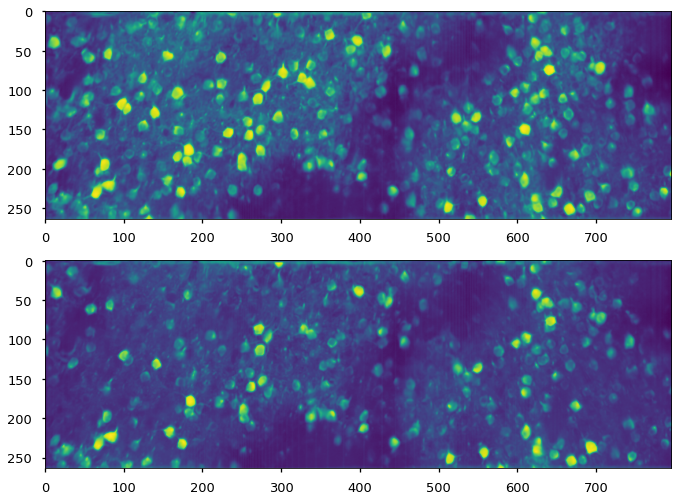

In [5]:
plt.subplot(311)
plt.imshow(Cn_list[0])

plt.subplot(312)
plt.imshow(Cn_list[1])

# plt.subplot(313)
# plt.imshow(Cn_list[2])

In [6]:
templates = [Cn_list[0], Cn_list[1],]# Cn_list[2]]
len(templates), templates[0].shape, type(templates)

(2, (264, 796), list)

## spatial footprint list
### find second pass threshold

In [7]:
gSig = [4, 4]
area_arr = []
aspect_ratio_arr = []

cnm = cnm_list[0]
Cn = Cn_list[0]
for component_id in tqdm(cnm_list[0].estimates.idx_components):
    clear_output(wait=True) # clear warning after a pause, otherwise cell output too long
    
    crd = plot_contours(cnm_list[0].estimates.A[:, component_id], Cn, thr=0.9, display_numbers=False);
    plt.close()
    range0 = np.nanmax(crd[0]['coordinates'][:,0]) - np.nanmin(crd[0]['coordinates'][:,0])
    range1 = np.nanmax(crd[0]['coordinates'][:,1]) - np.nanmin(crd[0]['coordinates'][:,1])
    aspect_ratio = range0 / (range1 + 1e-40)
    aspect_ratio_arr = np.append(aspect_ratio_arr, aspect_ratio)

    masks_ws, pos_examples, neg_examples = extract_binary_masks_blob(cnm_list[0].estimates.A[:, component_id], 
                                                                 neuron_radius=gSig[0], dims=Cn.shape)
    area = np.sum(masks_ws)
    area_arr = np.append(area_arr, area)

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


In [90]:
# component_id = cnm_list[0].estimates.idx_components[10]
# masks_ws, pos_examples, neg_examples = extract_binary_masks_blob(cnm_list[0].estimates.A[:, component_id], 
#                                                                  neuron_radius=gSig[0], dims=Cn.shape)
# plt.imshow(masks_ws[0,:,:])

(13, 417)

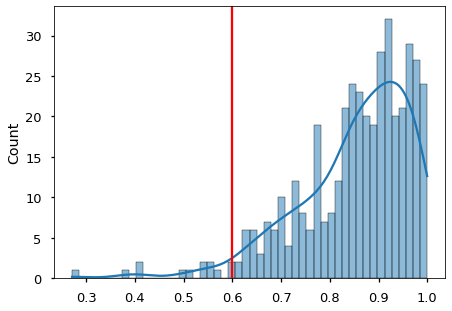

In [10]:
aspect_ratio_arr[aspect_ratio_arr>1] = 1/aspect_ratio_arr[aspect_ratio_arr>1]

plt.figure(figsize=(7,5))
sns.histplot(aspect_ratio_arr, bins=50, kde=True)
thres_ratio = 0.6
plt.axvline(thres_ratio, color='r')

sum((aspect_ratio_arr<thres_ratio) | (aspect_ratio_arr>1/thres_ratio)), len(aspect_ratio_arr)

(9, 417)

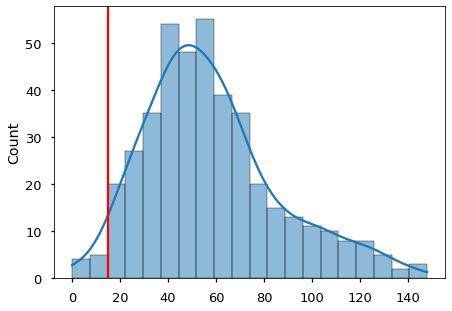

In [12]:
plt.figure(figsize=(7,5))
sns.histplot(area_arr, bins=20, kde=True)
thres_area = 15
plt.axvline(thres_area, color='r')

sum(area_arr<thres_area), len(area_arr)

### second pass

In [24]:
def caiman_additional_pass(cnm, idx_list, Cn, sort_by, save_flag):

    import pylab as pl
    from caiman.base.rois import com
    from caiman.utils.visualization import plot_contours, get_contours
    from caiman.base.rois import extract_binary_masks_blob
    from tqdm import tqdm
    
    pass_arr = []
    for component_id in tqdm(idx_list):
        clear_output(wait=True) # clear warning after a pause, otherwise cell output too long
        
        crd = plot_contours(cnm.estimates.A[:, component_id], Cn, thr=0.9, display_numbers=False);
        plt.close()
        
        # aspect ratio should not be extreme - dynamic thresholding
        range0 = np.nanmax(crd[0]['coordinates'][:,0]) - np.nanmin(crd[0]['coordinates'][:,0])
        range1 = np.nanmax(crd[0]['coordinates'][:,1]) - np.nanmin(crd[0]['coordinates'][:,1])
        aspect_ratio = range0 / (range1 + 1e-40)
        aspect_ratio_pass = (aspect_ratio<1/thres_ratio) and (aspect_ratio>thres_ratio)
        
        # height & width should not be small
        height_width_pass = (range0>=3) and (range1>=3)
            
        # cell should not only occupy edge space
        edge_radius = 5
        dims = Cn.shape
        edge_pass = ((np.nanmax(crd[0]['coordinates'][:,0])>edge_radius)
                     and (np.nanmin(crd[0]['coordinates'][:,0])<dims[1]-edge_radius)
                     and (np.nanmax(crd[0]['coordinates'][:,1])>edge_radius)
                     and (np.nanmin(crd[0]['coordinates'][:,1])<dims[0]-edge_radius))
            
        # area should not be small - dynamic thresholding
        gSig = [4, 4]
        masks_ws, _, _ = extract_binary_masks_blob(cnm.estimates.A[:, component_id], 
                                                       neuron_radius=gSig[0], dims=Cn.shape)
        plt.close()
        area = np.sum(masks_ws)
        area_pass = area>=thres_area
        area_pass = True # area pass is buggy, set true for now # todo
        
        # AND gate: if all pass, then add to pass_arr
        pass_flag = aspect_ratio_pass and height_width_pass and edge_pass and area_pass
        pass_arr = np.concatenate((pass_arr, pass_flag), axis=None)
        
        # plot cell & explain reasoning
        plt.clf()
        plt.figure()

        ypos = np.floor(crd[0]['CoM']).astype(int)[0] # y position of caiman segmented cell's center of mass
        proximity_range = 50 # plot how many pixels around CoM
        Cn_chunk = Cn[max(ypos-proximity_range, 0):min(ypos+proximity_range, Cn.shape[0]), :] # do not exceed Cn nrow
        plt.imshow(Cn_chunk)

        crd_converted = crd[0]['coordinates'].copy()
        crd_converted[:,1] = crd_converted[:,1] - max(ypos-proximity_range, 0) # origin (0 position) shifting due to edge
        pl.plot(*crd_converted.T, color='red', alpha=1)
        
        colors = ['r', 'b'] # false=red, true=black
        txt_ypos = 0.2
        plt.text(0.4, txt_ypos, 'aspect_ratio_pass: ' + str(aspect_ratio_pass) + ' ' + ('%.2f' % aspect_ratio), 
                 fontsize=14, color=colors[int(aspect_ratio_pass)], transform=plt.gcf().transFigure)
        plt.text(0.4, txt_ypos-0.02, 'height_width_pass: ' + str(height_width_pass) + ' ' + ('%.2f' % range0) + ' ' + ('%.2f' % range1),
                 fontsize=14, color=colors[int(height_width_pass)], transform=plt.gcf().transFigure)
        plt.text(0.4, txt_ypos-0.04, 'edge_pass: ' + str(edge_pass), 
                 fontsize=14, color=colors[int(edge_pass)], transform=plt.gcf().transFigure);
        plt.text(0.4, txt_ypos-0.06, 'area_pass: ' + str(area_pass) + ' ' + ('%.2f' % area), 
                 fontsize=14, color=colors[int(area_pass)], transform=plt.gcf().transFigure);

        if sort_by == 'aspect_ratio':
            score_string = 'aspect_ratio_' + str(aspect_ratio_pass)
        elif sort_by == 'height_width':
            score_string = 'height_width_' + str(height_width_pass)
        elif sort_by == 'edge':
            score_string = 'edge_' + str(edge_pass)
        elif sort_by == 'area':
            score_string = 'area_' + str(area_pass)
        else:
            score_string = 'pass_flag_' + str(pass_flag)
        
        filename = score_string + '_' + str(component_id)
        if save_flag == True:
            plt.savefig(filename +'.png', bbox_inches='tight')
            plt.close()
    
    return pass_arr

<Figure size 1296x936 with 0 Axes>

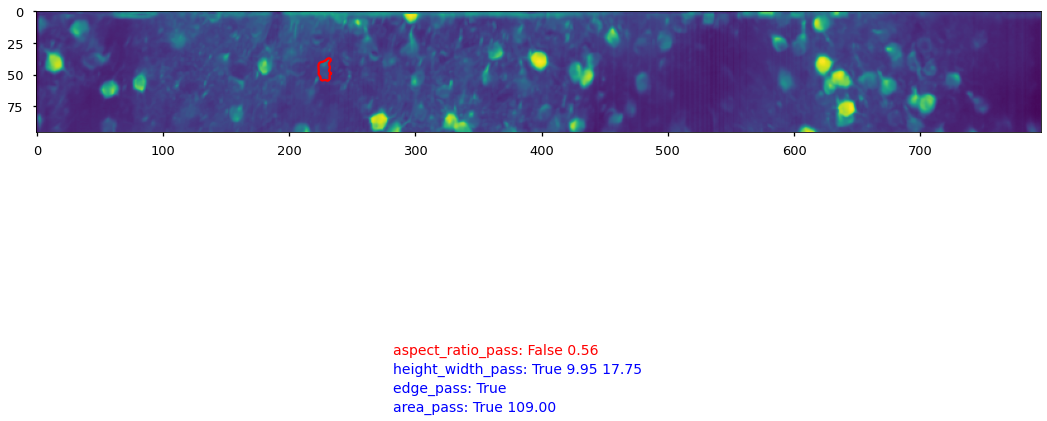

In [25]:
pass_arr = caiman_additional_pass(cnm_list[0], cnm_list[0].estimates.idx_components, Cn_list[0], sort_by=None, save_flag=True)
pass_arr0 = list(map(bool,pass_arr))

pass_arr = caiman_additional_pass(cnm_list[1], cnm_list[1].estimates.idx_components, Cn_list[1], sort_by=None, save_flag=False)
pass_arr1 = list(map(bool,pass_arr))

# pass_arr = caiman_additional_pass(cnm_list[2], cnm_list[2].estimates.idx_components, Cn_list[2], sort_by=None, save_flag=False)
# pass_arr2 = list(map(bool,pass_arr))

clear_output(wait=True)
# takes 3-6 min for bunnytop

In [26]:
print('%2d out of %2d cells from caiman passed secondary criteria: \
area, aspect ratio, height width, edge' 
      % ( len(cnm_list[0].estimates.idx_components[pass_arr0]), len(cnm_list[0].estimates.idx_components) )
     )
print('%2d out of %2d cells from caiman passed secondary criteria: \
area, aspect ratio, height width, edge' 
      % ( len(cnm_list[1].estimates.idx_components[pass_arr1]), len(cnm_list[1].estimates.idx_components) )
     )
# print('%2d out of %2d cells from caiman passed secondary criteria: \
# area, aspect ratio, height width, edge' 
#       % ( len(cnm_list[2].estimates.idx_components[pass_arr2]), len(cnm_list[2].estimates.idx_components) )
#      )

404 out of 417 cells from caiman passed secondary criteria: area, aspect ratio, height width, edge
391 out of 410 cells from caiman passed secondary criteria: area, aspect ratio, height width, edge


In [27]:
sp0 = cnm_list[0].estimates.A[:, cnm_list[0].estimates.idx_components[pass_arr0]]
sp1 = cnm_list[1].estimates.A[:, cnm_list[1].estimates.idx_components[pass_arr1]]
# sp2 = cnm_list[2].estimates.A[:, cnm_list[2].estimates.idx_components[pass_arr2]]

spatial = [sp0,sp1,]#sp2]
dims = templates[0].shape

len(spatial), spatial[0].shape, spatial[1].shape, #spatial[2].shape, type(spatial)

(2, (210144, 404), (210144, 391))

# multisess reg

In [28]:
spatial_union, assignments, matchings = register_multisession(A=spatial, dims=dims, templates=templates)
# 6 min for demo, 2 min for bunny500, <2 min for bunnytop

C:\Users\ll357\Miniconda3\envs\caiman\lib\site-packages\scipy\sparse\_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


returns 3 variables for further analysis:
- `spatial_union`: csc_matrix (# pixels X # total distinct components), the union of all ROIs across all sessions aligned to the FOV of the last session.
- `assignments`: ndarray (# total distinct components X # sessions). `assignments[i,j]=k` means that component `k` from session `j` has been identified as component `i` from the union of all components, otherwise it takes a `NaN` value. Note that for each `i` there is at least one session index `j` where `assignments[i,j]!=NaN`.
- `matchings`: list of (# sessions) lists. Saves `spatial_union` indices of individual components in each session. `matchings[j][k] = i` means that component `k` from session `j` is represented by component `i` in the union of all components `spatial_union`. In other words `assignments[matchings[j][k], j] = j`.

In [29]:
assert len(spatial) == len(templates)
n_reg = len(templates)  # minimal number of sessions that each component has to be registered in
# Use number of non-NaNs in each row to filter out components that were not registered in enough sessions
assignments_filtered = np.array(assignments[np.sum(~np.isnan(assignments), axis=1) >= n_reg], dtype=int);
# Use filtered indices to select the corresponding spatial components
spatial_filtered = spatial[0][:, assignments_filtered[:, 0]]

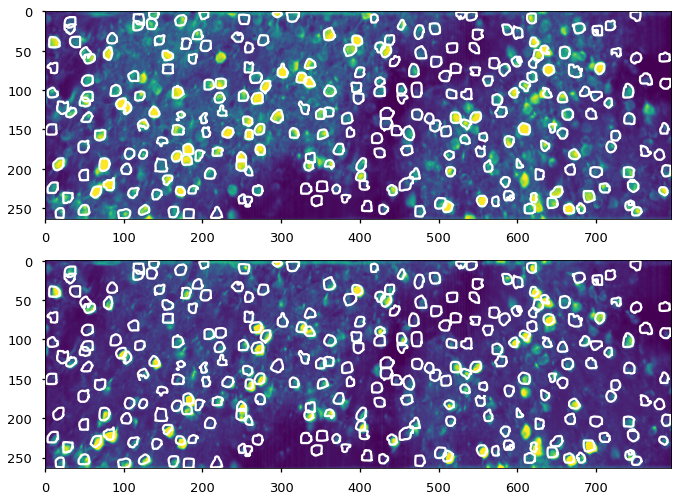

In [30]:
plt.subplot(311)
visualization.plot_contours(spatial_filtered, templates[0], display_numbers=False);
plt.subplot(312)
visualization.plot_contours(spatial_filtered, templates[1], display_numbers=False);
# plt.subplot(313)
# visualization.plot_contours(spatial_filtered, templates[2], display_numbers=False);

# extract activity

In [31]:
cnm_list = [cnm_list[0], cnm_list[1],]# cnm_list[2]]
df = np.zeros(assignments_filtered.shape, dtype=np.ndarray)
for i in range(df.shape[0]):
    for j in range(df.shape[1]):
        df[i,j] = cnm_list[j].estimates.F_dff[int(assignments_filtered[i,j]), :]

print(df.shape)
df.shape, df[0,0].shape, df[0,1].shape, #df[0,2].shape

(256, 2)


((256, 2), (80000,), (80000,))

In [32]:
from scipy.io import savemat
mdic = {"df": df}
savemat(f"caiman_activity_{mouse_date}_multisess.mat", mdic)